<a href="https://colab.research.google.com/github/hayannn/AIFFEL_STUDY/blob/main/7_3_%ED%8F%89%EA%B7%A0_%EC%9D%B4%EB%8F%99(Mean_Shift).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. 평균 이동
## Mean Shift 개요
- 중심에 소속된 데이터의 평균 거리 중심으로 이동하는 K-Means와 달리, 평균 이동은 중심을 데이터가 모여 있는 **밀도가 가장 높은 곳**으로 이동시킴
- 평균 이동 군집화는 데이터 분포도를 이용해 군집 중심점 찾음
  - 확률 밀도 함수 이용
  - KDE(Kernel Density Estimation) 이용
- 특정 데이터를 반경 내의 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤 그 반환 값을 현재 위치에서 업데이트하면서 이동하는 방식을 취함 ➡️ 전체 데이터에 반복 적용해 데이터 군집 중심점을 찾아냄

- KDE
  - 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정
  - 관측된 데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 -> 데이터 건수로 나눠 확률 밀도 함수 추정
  - 개별 관측 데이터에 커널 함수를 적용 -> 적용값을 모두 더한 후 개별 관측 데이터의 건수로 나눠 확률 밀도 함수 추정
  - 커널 함수 : 가우시안 분포 함수가 사용됨

- PDF
  - 확률 밀도 함수(Probability Density Function)
  - 확률 변수의 분포를 나타내는 함수
  - 널리 알려진 정규분포 함수 포함 감마 분포, t-분포 등 있음
  - 이를 이용하면 특정 변수가 어떤 값을 가지게 될지에 대한 확률을 알게 되어 변수의 특성, 확률 분포 등 변수의 많은 요소 파악 가능

- KDE를 표현하기 위한 커널 함수식
$$
\text{KDE} = \frac{1}{n} \sum_{i=1}^{n} K_h(x - x_i) = \frac{1}{n h} \sum_{i=1}^{n} K \left( \frac{x - x_i}{h} \right)
$$
  - h : 대역폭, KDE 형태를 부드러운(또는 뾰족한) 형태로 평활화 -> 이 설정에 따라 확률 밀도 추정 성능을 크게 좌우할 수 있음
  - 작은 h 값 : 좁고 뾰족한 KDE를 가지게 되어 변동성이 큰 방식으로 확률 밀도 함수를 추정해 과적합하기 쉬움
  - 큰 h 값 : 과도하게 평활화된 KDE로 인해 지나치게 단순화된 방식으로 확률 밀도 함수 추정해 과소적합하기 쉬움
  - 적절한 대역폭을 계산하는 것이 KDE 기반 평균 이동 군집화에서 매우 중요!

<br>

- 평균 이동 군집화의 일반화된 특징
  - 대역폭이 평활화된 KDE로 인해 적은 수의 군집 중심점을 가짐
  - 대역폭이 적을수록 많은 수의 군집 중심점을 가짐
  - 군집 개수를 지정하지 않음
  - 오직 대역폭 크기에 따라 군집화 수행

- 사이킷런 MeanShift 클래스
  - 가장 중요한 초기화 파라미터 : `bandwidth` == KDE의 대역폭 h와 동일
  - 최적 대역폭 계산을 위해 estimate_bandwidth() 함수 제공

<br>

- make_blobs()의 cluster_std를 0.7로 정한 3개 군집 데이터에 대해 bandwidth를 0.8로 설정한 평균 이동 군집화 알고리즘 적용 예제

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3,
                  cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


- 0~5까지 6개로 분류됨 -> 지나치게 세분화됨
- bandwidth 값을 작게 할수록 군집 개수 많아짐

<br>

- bandwidth를 1.0으로 살짝 높여서 MeanShift 수행

In [2]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- 3개로 적절히 잘 군집화됨
- MeanShift는 이 bandwidth를 최적화 값으로 설정하는 것이 매우 중요!

<br>

- estimate_bandwidth() 파라미터로 피쳐 데이터 세트를 입력해주면 최적화된 bandwidth 값을 반환해줌

In [3]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


<br>

- estimate_bandwidth()로 측정된 bandwidth를 평균 이동 입력값으로 적용해 동일한 make_blobs() 데이터 세트에 군집화를 수행

In [4]:
import pandas as pd


clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift= MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


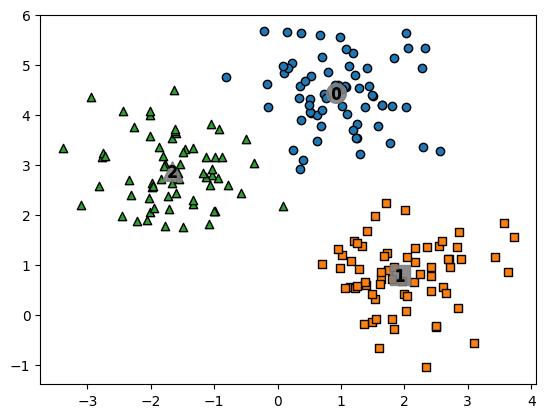

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label] )

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

- Target 값과 군집 label 값 비교(1:1로 잘 매칭됨!)

In [6]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


- 평균 이동의 장점
  - 데이터 세트 형태를 특정 형태로 가정하거나, 특정 분포도 기반의 모델로 가정하지 않아 좀 더 유연한 군집화 가능
  - 이상치 영향력도 크지 않고, 미리 군집 개수를 정할 필요도 없음!
  - 알고리즘 수행 시간 오래 걸림 + bandwidth 크기에 따른 군집화 영향도 매우 큼!
  - 그래서 주로 CV 영역에서 사용 ➡️ 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘임